In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

def preprocess_data(X, y, n_samples=None):
    if n_samples is not None:
        X = X[:n_samples]
        y = y[:n_samples]

    # Flatten images from (num_samples, 28, 28) -> (num_samples, 784)
    X_flat = X.reshape(X.shape[0], -1).astype('float32')

    # Normalize pixel values to [0,1]
    X_norm = MinMaxScaler().fit_transform(X_flat)

    # One-hot encode labels
    y_onehot = np.zeros((len(y), 10))
    y_onehot[np.arange(len(y)), y] = 1

    return X_norm, y_onehot

# Use only 10,000 samples for faster training
X_train_prep, y_train_prep = preprocess_data(X_train, y_train, n_samples=10000)
X_test_prep, y_test_prep = preprocess_data(X_test, y_test)

print("Data shapes:")
print("Train images:", X_train_prep.shape)
print("Train labels:", y_train_prep.shape)
print("Test images:", X_test_prep.shape)

2025-06-18 16:20:50.655106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750252850.727528   12786 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750252850.747942   12786 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750252850.797940   12786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750252850.798004   12786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750252850.798011   12786 computation_placer.cc:177] computation placer alr

Data shapes:
Train images: (10000, 784)
Train labels: (10000, 10)
Test images: (10000, 784)


In [2]:
class PredictiveCodingModel:
    def __init__(self, layer_sizes=[784, 256, 10], learning_rate=0.001, n_iterations=5):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        
        # Initialize weights using He initialization
        self.weights = []
        for i in range(len(layer_sizes)-1):
            std = np.sqrt(2. / layer_sizes[i])
            self.weights.append(np.random.normal(0, std, (layer_sizes[i+1], layer_sizes[i])))
        
        # Initialize lateral connections (between same-layer features)
        self.lateral_weights = []
        for size in layer_sizes[1:]:
            self.lateral_weights.append(0.01 * np.random.randn(size, size))
    
    def sigmoid(self, x):
        """Numerically stable sigmoid function"""
        return np.where(x >= 0, 
                        1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid used in gradient computation"""
        return np.clip(x * (1 - x), 1e-8, 1)
    
    def forward_pass(self, x):
        """Compute predictions at each layer given current activity"""
        layer_predictions = []
        current_activity = x
        
        for i in range(len(self.weights)):
            prediction = self.sigmoid(np.dot(self.weights[i], current_activity))
            layer_predictions.append(prediction)
            current_activity = prediction
        
        return layer_predictions
    
    def update_states_and_weights(self, x, y, verbose=False):
        """
        Update internal states and weights based on prediction errors
        If verbose=True, prints layer-wise info
        """
        # Initial states (input + predictions)
        states = [x.copy()]
        predictions = self.forward_pass(x)
        states.extend(predictions)
        states[-1] = y.copy()  # Ground truth for final layer

        # Initialize prediction errors
        errors = [np.zeros_like(s) for s in states]

        # Iteratively refine states
        for iter_num in range(self.n_iterations):
            # Top-down error propagation
            for l in reversed(range(1, len(states))):
                if l == len(states) - 1:
                    errors[l] = states[l] - predictions[l-1]
                else:
                    error_from_above = np.dot(self.weights[l].T, errors[l+1])
                    lateral_error = np.dot(self.lateral_weights[l-1], errors[l])
                    errors[l] = error_from_above + 0.1 * lateral_error - (states[l] - predictions[l-1])

                # State update
                delta_state = 0.1 * self.learning_rate * np.clip(errors[l], -10, 10)
                if l > 0:
                    delta_state *= self.sigmoid_derivative(states[l])
                states[l] += delta_state
            
            # Recompute predictions after updating states
            for l in range(len(self.weights)):
                predictions[l] = self.sigmoid(np.dot(self.weights[l], states[l]))
            
            if verbose and iter_num == self.n_iterations - 1:
                print(f"\n--- Final Iteration Updates ---")
                for l in range(len(states)):
                    print(f"Layer {l} | State shape: {states[l].shape} | Error norm: {np.linalg.norm(errors[l]):.4f}")
                for l in range(len(self.weights)):
                    print(f"Weight {l} shape: {self.weights[l].shape}")

        # Update weights using prediction errors
        for l in range(len(self.weights)):
            grad_weight = np.outer(
                np.clip(errors[l+1], -5, 5) * self.sigmoid_derivative(states[l+1]), 
                states[l]
            )
            self.weights[l] += self.learning_rate * np.clip(grad_weight, -0.1, 0.1)
            
            if l > 0:
                grad_lateral = np.outer(
                    np.clip(errors[l], -5, 5), 
                    np.clip(errors[l], -5, 5)
                )
                self.lateral_weights[l-1] += 0.01 * self.learning_rate * grad_lateral

        return predictions, errors

    def train(self, X, y, epochs=5, batch_size=32, display_interval=1):
        n_samples = X.shape[0]
        print(f"Training on {n_samples} samples for {epochs} epochs...")
        
        for epoch in range(epochs):
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            epoch_loss = 0
            correct = 0
            
            for i in range(0, n_samples, batch_size):
                batch_X = X_shuffled[i:i+batch_size]
                batch_y = y_shuffled[i:i+batch_size]
                
                batch_loss = 0
                batch_correct = 0
                
                for j in range(batch_X.shape[0]):
                    predictions, errors = self.update_states_and_weights(batch_X[j], batch_y[j])
                    
                    # L2 regularization
                    reg_loss = sum(0.001 * np.sum(w**2) for w in self.weights)
                    loss = 0.5 * np.sum(errors[-1]**2) + reg_loss
                    batch_loss += loss
                    
                    predicted_class = np.argmax(predictions[-1])
                    true_class = np.argmax(batch_y[j])
                    if predicted_class == true_class:
                        batch_correct += 1
                
                epoch_loss += batch_loss / batch_size
                correct += batch_correct
            
            accuracy = correct / n_samples
            if (epoch + 1) % display_interval == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/n_samples:.4f}, Accuracy: {accuracy:.4f}")
    
    def predict(self, X):
        predictions = []
        for x in X:
            pred = self.forward_pass(x)[-1]
            predictions.append(pred)
        return np.array(predictions)

In [ ]:
# Initialize the model
pc_model = PredictiveCodingModel(layer_sizes=[784, 256, 10], learning_rate=0.001, n_iterations=5)

# Train the model
pc_model.train(X_train_prep, y_train_prep, epochs=15, batch_size=32, display_interval=1)

Training on 10000 samples for 5 epochs...
Epoch 1/5, Loss: 0.0325, Accuracy: 0.3921
Epoch 2/5, Loss: 0.0289, Accuracy: 0.6853
Epoch 3/5, Loss: 0.0280, Accuracy: 0.7435
Epoch 4/5, Loss: 0.0276, Accuracy: 0.7754
Epoch 5/5, Loss: 0.0275, Accuracy: 0.7964


In [4]:
# Predict on test set
y_pred_probs = pc_model.predict(X_test_prep)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_prep, axis=1)

# Compute accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.7978


In [5]:
# Pick one sample
sample_index = 0
x_sample = X_test_prep[sample_index]
y_sample = y_test_prep[sample_index]

# Run inference with verbose mode to see internals
_, errors = pc_model.update_states_and_weights(x_sample, y_sample, verbose=True)

# Reconstruct predictions
predictions = pc_model.forward_pass(x_sample)

# Print details per layer
for l in range(len(predictions)):
    print(f"\nLayer {l+1} Prediction Shape: {predictions[l].shape}")
    print(f"Prediction: {predictions[l][:5]}...")  # Show first 5
    print(f"Error: {errors[l+1][:5]}...")
    print(f"Weights incoming: {pc_model.weights[l].shape}")


--- Final Iteration Updates ---
Layer 0 | State shape: (784,) | Error norm: 0.0000
Layer 1 | State shape: (256,) | Error norm: 0.7723
Layer 2 | State shape: (10,) | Error norm: 0.5381
Weight 0 shape: (256, 784)
Weight 1 shape: (10, 256)

Layer 1 Prediction Shape: (256,)
Prediction: [0.93066799 0.9015821  0.74255974 0.11018316 0.1027902 ]...
Error: [ 2.57582054e-02  8.95227338e-06  5.67341486e-03 -9.80899872e-02
 -1.41856041e-02]...
Weights incoming: (256, 784)

Layer 2 Prediction Shape: (10,)
Prediction: [0.09068332 0.04077914 0.13070352 0.17257048 0.12498988]...
Error: [-0.09069008 -0.04077358 -0.13072832 -0.17260915 -0.12501547]...
Weights incoming: (10, 256)


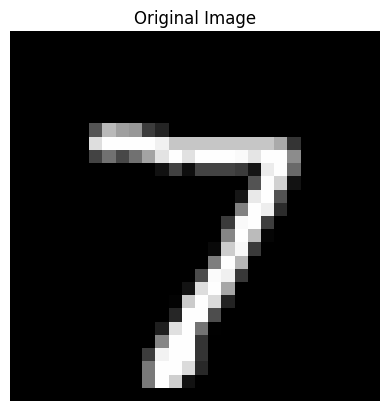

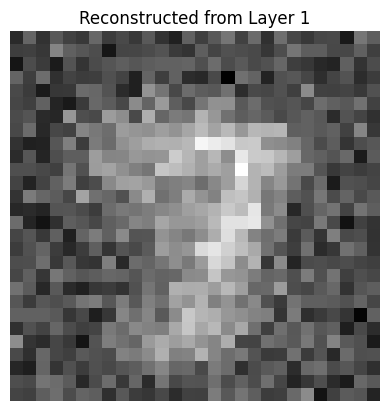

In [6]:
def plot_image(img, title=""):
    plt.imshow(img.reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Original image
plot_image(x_sample, "Original Image")

# Reconstructed image from first layer (decoder-style)
first_layer_reconstruction = pc_model.weights[0].T @ predictions[0]
plot_image(first_layer_reconstruction, "Reconstructed from Layer 1")